## **below code is to calculate lipid bilayerthickness in nanodiscs** ##

Loading Universe from /home/ebam/ravi1/phd/14A_apoa1/new_apporach/new/12_dimers/cubic_bigbox/charmm-gui-9583052457/gromacs/dmpc_peptide.gro and /home/ebam/ravi1/phd/14A_apoa1/new_apporach/new/12_dimers/cubic_bigbox/charmm-gui-9583052457/gromacs/aligned_full_trajectory_combined.xtc...
Found 186 phosphate atoms.
Top leaflet phosphates: 93
Bottom leaflet phosphates: 93
Box size (X, Y, Z): 152.00 x 152.00 x 152.00 Å
Bin size: 2.00 Å => Grid: 76 x 76
Processing frame: 4001
Total frames analyzed: 4002
Overall average bilayer thickness: 36.570 Å


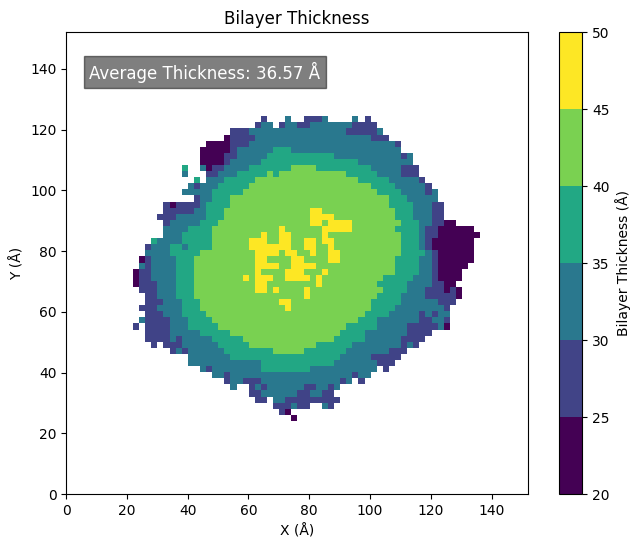

thickness_map.dat written to disk.


In [ ]:

import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# For discrete color zones
import matplotlib as mpl

################################################################################
# 3. User parameters
################################################################################
gro_file = "/home/ebam/ravi1/phd/14A_apoa1/new_apporach/new/12_dimers/cubic_bigbox/charmm-gui-9583052457/gromacs/dmpc_peptide_combine.gro"       # Path to your GRO file
xtc_file = "/home/ebam/ravi1/phd/14A_apoa1/new_apporach/new/12_dimers/cubic_bigbox/charmm-gui-9583052457/gromacs/aligned_full_trajectory_combined.xtc"  # Path to your XTC file
phosphate_sel = "name P"  # Selection for phosphate atoms
bin_size = 2.0            # Bin size in X and Y (Å)
frame_skip = 1            # Analyze every Nth frame

# Define thickness "zones" or intervals (in Å) for the color scale
# Example: from 20 Å to 50 Å in 5 Å increments.
thickness_levels = np.arange(20, 55, 5)

################################################################################
# 4. Load Universe and select phosphates
################################################################################

print(f"Loading Universe from {gro_file} and {xtc_file}...")
u = mda.Universe(gro_file, xtc_file)
phosphates = u.select_atoms(phosphate_sel)

if phosphates.n_atoms == 0:
    raise ValueError(f"No atoms found for selection: '{phosphate_sel}'")

print(f"Found {phosphates.n_atoms} phosphate atoms.")

################################################################################
# 5. Classify top vs. bottom leaflet by Z coordinate (first frame)
################################################################################

u.trajectory[0]  # Go to the first frame
z_coords = phosphates.positions[:, 2]
z_mid = np.mean(z_coords)

top_indices = []
bottom_indices = []

for i, zval in enumerate(z_coords):
    if zval > z_mid:
        top_indices.append(phosphates[i].ix)
    else:
        bottom_indices.append(phosphates[i].ix)

top_sel_str = "index " + " ".join(str(ix) for ix in top_indices)
bot_sel_str = "index " + " ".join(str(ix) for ix in bottom_indices)

top_leaflet = u.select_atoms(top_sel_str)
bot_leaflet = u.select_atoms(bot_sel_str)

print(f"Top leaflet phosphates: {top_leaflet.n_atoms}")
print(f"Bottom leaflet phosphates: {bot_leaflet.n_atoms}")

################################################################################
# 6. Create 2D bins in X and Y
################################################################################

box = u.dimensions[:3]  # [lx, ly, lz]
lx, ly, lz = box
n_bins_x = int(np.floor(lx / bin_size))
n_bins_y = int(np.floor(ly / bin_size))

print(f"Box size (X, Y, Z): {lx:.2f} x {ly:.2f} x {lz:.2f} Å")
print(f"Bin size: {bin_size:.2f} Å => Grid: {n_bins_x} x {n_bins_y}")

# Prepare arrays to accumulate thickness
thickness_sum = np.zeros((n_bins_x, n_bins_y), dtype=np.float64)
thickness_count = np.zeros((n_bins_x, n_bins_y), dtype=np.int64)

################################################################################
# 7. Main loop to compute thickness per frame
################################################################################

frame_count = 0

for ts in u.trajectory[::frame_skip]:
    # Bottom leaflet coords
    bot_xy = bot_leaflet.positions[:, :2]  # shape (N_bottom, 2)
    bot_z  = bot_leaflet.positions[:, 2]

    # KD-tree in 2D for bottom leaflet
    bot_tree = cKDTree(bot_xy)

    # Top leaflet coords
    top_xy = top_leaflet.positions[:, :2]  # shape (N_top, 2)
    top_z  = top_leaflet.positions[:, 2]

    # Find nearest bottom phosphate in XY for each top phosphate
    dists, indices = bot_tree.query(top_xy)
    thicknesses = top_z - bot_z[indices]  # z_top - z_bottom

    # Bin each thickness by the top phosphate’s (x, y)
    x_bin_indices = (top_xy[:, 0] // bin_size).astype(int)
    y_bin_indices = (top_xy[:, 1] // bin_size).astype(int)

    for i in range(len(top_xy)):
        ix = x_bin_indices[i]
        iy = y_bin_indices[i]
        if 0 <= ix < n_bins_x and 0 <= iy < n_bins_y:
            thickness_sum[ix, iy] += thicknesses[i]
            thickness_count[ix, iy] += 1

    frame_count += 1
    print(f"Processing frame: {ts.frame}", end="\r")

print(f"\nTotal frames analyzed: {frame_count}")

################################################################################
# 8. Compute average thickness map
################################################################################

with np.errstate(invalid='ignore'):
    avg_thickness_map = thickness_sum / np.where(thickness_count > 0, thickness_count, 1)

# Fill bins with no data with np.nan
avg_thickness_map[thickness_count == 0] = np.nan

################################################################################
# 8a. Compute overall average thickness
################################################################################

overall_avg_thickness = np.nanmean(avg_thickness_map)
print(f"Overall average bilayer thickness: {overall_avg_thickness:.3f} Å")

################################################################################
# 9. Plot as a heatmap with discrete "zones" in the color scale
################################################################################

# Prepare figure
plt.figure(figsize=(8, 6))

# We'll define a discrete color norm based on thickness_levels
norm = mpl.colors.BoundaryNorm(boundaries=thickness_levels, ncolors=256)

# Plot using imshow
cax = plt.imshow(
    avg_thickness_map.T, 
    origin='lower',
    extent=[0, n_bins_x * bin_size, 0, n_bins_y * bin_size],
    cmap='viridis',
    norm=norm,
    aspect='equal'
)

# Add colorbar with the levels
cbar = plt.colorbar(cax, ticks=thickness_levels, label='Thickness (Å)')
cbar.set_label('Bilayer Thickness (Å)')

plt.title('Bilayer Thickness')
plt.xlabel('X (Å)')
plt.ylabel('Y (Å)')

# Optionally, annotate the average thickness on the plot (if you like):
plt.text(
    0.05 * n_bins_x * bin_size,
    0.90 * n_bins_y * bin_size,
    f"Average Thickness: {overall_avg_thickness:.2f} Å",
    color='white',
    fontsize=12,
    bbox=dict(facecolor='black', alpha=0.5)
)

plt.show()

################################################################################
# 10. Optional: Save data to file
################################################################################

np.savetxt("thickness_map.dat", avg_thickness_map, fmt="%.3f")
print("thickness_map.dat written to disk.")


# **calculating the lipid order parameter** #

In [2]:
conda install ipywigets 


\ 
Note: you may need to restart the kernel to use updated packages.


# *cpu parallelization*#

Processing frames 0 to 4000 (step 1) on 56 CPUs...


100%|██████████| 4000/4000 [24:05<00:00,  2.77it/s] 


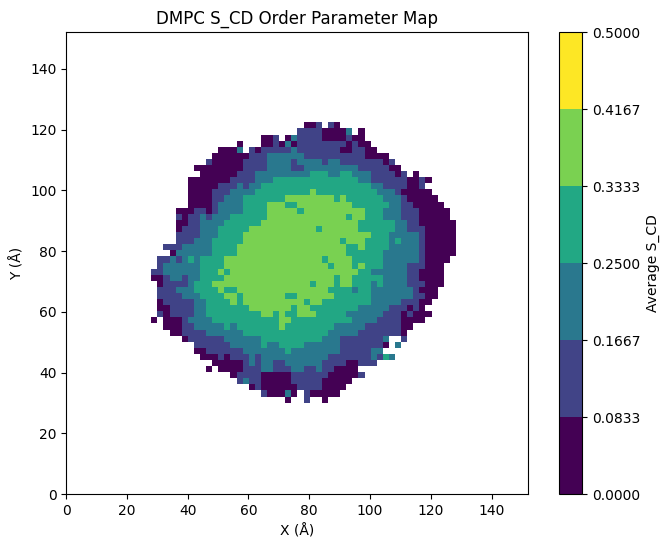

scd_map.dat written to disk.


In [24]:
import os
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import multiprocessing

# Global variables for each worker (set in init_worker)
global_u = None
n_bins_x = None
n_bins_y = None
bin_size = None
tail1_sel = None
tail2_sel = None
bond_cutoff = None

def init_worker(psf, xtc, bin_size_val, tail1_sel_str, tail2_sel_str, bond_cutoff_val):
    """
    Each worker process creates its own MDAnalysis Universe instance.
    This avoids pickling the Universe object across processes.
    """
    global global_u, n_bins_x, n_bins_y, bin_size, tail1_sel, tail2_sel, bond_cutoff
    bin_size = bin_size_val
    tail1_sel = tail1_sel_str
    tail2_sel = tail2_sel_str
    bond_cutoff = bond_cutoff_val
    global_u = mda.Universe(psf, xtc)
    # Set the first frame to get the box dimensions
    global_u.trajectory[0]
    lx, ly, lz = global_u.dimensions[:3]
    n_bins_x = int(np.floor(lx / bin_size))
    n_bins_y = int(np.floor(ly / bin_size))
    # Optional: print grid info for debugging
    # print(f"[Worker] Box: {lx:.2f} x {ly:.2f} x {lz:.2f} Å; Grid: {n_bins_x} x {n_bins_y}")

def compute_order_parameter(carbon_pos, hydrogen_pos, ez=np.array([0, 0, 1], dtype=float)):
    """
    Compute S_CD = -0.5*(3*cos^2(theta) - 1),
    where theta is the angle between the C–H bond vector and the z-axis.
    """
    vec = hydrogen_pos - carbon_pos
    norm = np.linalg.norm(vec)
    if norm == 0:
        return np.nan
    cos_theta = np.dot(vec, ez) / norm
    return -0.5 * (3 * cos_theta**2 - 1)

def guess_bonded_hydrogens(carbon, residue, cutoff):
    """
    Guess bonded hydrogens as those hydrogens in the residue (name starts with "H")
    that lie within a distance 'cutoff' from the carbon.
    """
    hydrogens = residue.atoms.select_atoms("name H*")
    candidates = []
    for H in hydrogens:
        if np.linalg.norm(carbon.position - H.position) < cutoff:
            candidates.append(H)
    return candidates

def process_frame(frame_idx):
    """
    Process a single frame:
    - Set the Universe to the given frame index.
    - Loop over every DMPC lipid (each residue) and compute the average S_CD
      from both tails (using distance-based guesses for bonded hydrogens).
    - Bin the per–lipid S_CD value by the lipid's XY center-of-mass.
    Returns two arrays:
      scd_sum_frame: sum of S_CD values per bin for this frame.
      scd_count_frame: count of contributions per bin for this frame.
    """
    global global_u, n_bins_x, n_bins_y, bin_size, tail1_sel, tail2_sel, bond_cutoff
    global_u.trajectory[frame_idx]
    scd_sum_frame = np.zeros((n_bins_x, n_bins_y), dtype=np.float64)
    scd_count_frame = np.zeros((n_bins_x, n_bins_y), dtype=np.int64)
    
    # Select all DMPC lipids (assumed each residue is one lipid)
    lipid_residues = global_u.select_atoms("resname DMPC").residues
    for res in lipid_residues:
        s_vals = []
        # Process Tail 1: select carbons matching tail1_sel
        tail1_atoms = res.atoms.select_atoms(tail1_sel)
        for C in tail1_atoms:
            H_candidates = guess_bonded_hydrogens(C, res, bond_cutoff)
            for H in H_candidates:
                s_val = compute_order_parameter(C.position, H.position)
                if not np.isnan(s_val):
                    s_vals.append(s_val)
        # Process Tail 2: select carbons matching tail2_sel
        tail2_atoms = res.atoms.select_atoms(tail2_sel)
        for C in tail2_atoms:
            H_candidates = guess_bonded_hydrogens(C, res, bond_cutoff)
            for H in H_candidates:
                s_val = compute_order_parameter(C.position, H.position)
                if not np.isnan(s_val):
                    s_vals.append(s_val)
        # If we have any S_CD values for this lipid, average them and bin by the lipid's COM.
        if s_vals:
            S_lipid = np.mean(s_vals)
            com = res.atoms.center_of_mass()
            x, y = com[0], com[1]
            ix = int(x // bin_size)
            iy = int(y // bin_size)
            if 0 <= ix < n_bins_x and 0 <= iy < n_bins_y:
                scd_sum_frame[ix, iy] += S_lipid
                scd_count_frame[ix, iy] += 1
    return scd_sum_frame, scd_count_frame

def main():
    # 1. User Parameters (set for your system)
    psf_file = "/home/ebam/ravi1/phd/14A_apoa1/new_apporach/new/12_dimers/cubic_bigbox/charmm-gui-9583052457/gromacs/step3_input.psf"
    xtc_file = "/home/ebam/ravi1/phd/14A_apoa1/new_apporach/new/12_dimers/cubic_bigbox/charmm-gui-9583052457/gromacs/aligned_concatenated_trajectory.xtc"
    
    tail1_sel_str = "name C3*"
    tail2_sel_str = "name C2*"
    bin_size_val = 2            # Bin size in Å
    # Frame selection parameters:
    start_frame = 0             # First frame (0-indexed)
    end_frame = 4000            # Last frame to process (exclusive)
    frame_step = 1              # Process every frame in the specified range
    
    scd_levels = np.linspace(0, 0.5, 7)  # Discrete color zones for S_CD map
    bond_cutoff_val = 1.2               # Distance cutoff for bonded hydrogen guess
    
    # Create a temporary Universe to get the total number of frames and grid dimensions
    u_temp = mda.Universe(psf_file, xtc_file)
    u_temp.trajectory[0]
    lx, ly, lz = u_temp.dimensions[:3]
    n_bins_x_main = int(np.floor(lx / bin_size_val))
    n_bins_y_main = int(np.floor(ly / bin_size_val))
    total_frames = len(u_temp.trajectory)
    if end_frame > total_frames:
        end_frame = total_frames
    frame_indices = list(range(start_frame, end_frame, frame_step))
    
    # Use the grid dimensions computed in main for the accumulator arrays.
    print(f"Processing frames {start_frame} to {end_frame} (step {frame_step}) on {multiprocessing.cpu_count()} CPUs...")
    
    # Create a pool of workers; each initializes its own Universe.
    with multiprocessing.Pool(processes=multiprocessing.cpu_count(),
                              initializer=init_worker,
                              initargs=(psf_file, xtc_file, bin_size_val, tail1_sel_str, tail2_sel_str, bond_cutoff_val)
                             ) as pool:
        results = list(tqdm(pool.imap(process_frame, frame_indices), total=len(frame_indices)))
    
    # Combine results from all frames using grid dimensions computed in main
    scd_sum_total = np.zeros((n_bins_x_main, n_bins_y_main), dtype=np.float64)
    scd_count_total = np.zeros((n_bins_x_main, n_bins_y_main), dtype=np.int64)
    for s_sum, s_count in results:
        scd_sum_total += s_sum
        scd_count_total += s_count
    
    # Compute the average S_CD per bin.
    with np.errstate(divide="ignore", invalid="ignore"):
        avg_scd_map = scd_sum_total / np.where(scd_count_total > 0, scd_count_total, 1)
    avg_scd_map[scd_count_total == 0] = np.nan
    
    # Plot the heatmap.
    plt.figure(figsize=(8, 6))
    norm = mpl.colors.BoundaryNorm(boundaries=scd_levels, ncolors=256)
    cax = plt.imshow(avg_scd_map.T,
                     origin='lower',
                     extent=[0, n_bins_x_main * bin_size_val, 0, n_bins_y_main * bin_size_val],
                     cmap='viridis',
                     norm=norm,
                     aspect='equal')
    cbar = plt.colorbar(cax, ticks=scd_levels)
    cbar.set_label("Average S_CD")
    plt.title("DMPC S_CD Order Parameter Map")
    plt.xlabel("X (Å)")
    plt.ylabel("Y (Å)")
    plt.show()
    
    # Optionally, save the S_CD map to a file.
    np.savetxt("scd_map.dat", avg_scd_map, fmt="%.3f")
    print("scd_map.dat written to disk.")

if __name__ == '__main__':
    main()
